# __Assignment 2__

## __Short Report__

### __Data__
The first thing I do is to read the data from the given URL and prepare it for the model. 

I start with feature engineering where I convert the Month column into an integer column from 1 to 12. Where 1 represents January and so on. Then I prepare the target variable by shifting the Passenger column by -1. This means that the target value for each row will be the next rows passenger count.

The next step is splitting the data into training and test data. The first 70 % of the rows are set to training, while the remaining rows are used for the test set. 

After the datasplit I scale the data into the range (0, 1). The scaler is fitted on the training data. This is done to not get any data leakage into to the test set and make sure that the scaled values in train and test are equivalent. 

The final data step is to convert the numpy arrays into pytorch tensors and cunstruct the datasets and dataloaders for training and test. 

### __The model__
The model consits of a one layered LSTM and a linear layer. The LSTM handles the time steps. The last linear layer takes the flattened final hidden state from the LSTM and maps it to it's final prediction. We calculate the mean squared error between the actual target value and this prediciton as the loss. 

The model is initiated with two features and 100 units in the hidden dimension. The learning rate is set to 1e-3 and the optimizer ADAM. Finally the model is trained for 150 epochs with shuffled batches of size 3. 

### __The results__
The model makes fairly decent predictions and achieves a MSE of 0.022. 



In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [ ]:
csv_path = "https://raw.githubusercontent.com/blue-yonder/pydse/master/pydse/data/international-airline-passengers.csv"
df = pd.read_csv(csv_path, delimiter=";")

# I decided to the this assignment in a slightly different way than you suggested.
# I also include a feature for the month, this is to capture seasonal effects 
# which might be represented in the month. 
df = df.assign(month=lambda x: x.Month.str.slice(start=5))
df_2feats = df[["Passengers", "month"]]

[]

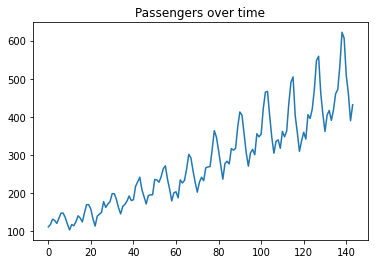

In [ ]:
df.Passengers.plot(title="Passengers over time")
plt.plot()

In [ ]:
# I make the target variable y. This causes us to lose 1 
# degree of freedom, so I drop the last row with missing
# target value 
df_2feats["y"] = df_2feats.Passengers.shift(-1)
df_2feats = df_2feats.dropna()

In [ ]:
# Split the data into train and test
prc_70 = int(len(df_2feats) * 0.7)
train = df_2feats[:prc_70]
test = df_2feats[prc_70:]

In [ ]:
# scale data into the range (0, 1)
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
# turn the data into X and y tensors
X_train = torch.from_numpy(train_scaled[:, [0,1]])
y_train = torch.from_numpy(train_scaled[:, 2])

X_test = torch.from_numpy(test_scaled[:,[0,1]])
y_test = torch.from_numpy(test_scaled[:,2])

In [ ]:
class PassengerData(Dataset):
    def __init__(self, X, y, seq_len=1):
        self.seq_len = seq_len
        # cast y and X values as floats 
        self.y = y.float()
        self.X = X.float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i:i+1, :], self.y[i]

In [ ]:
# make datasets and dataloaders for simplicity 
torch.manual_seed(420)

train_dataset = PassengerData(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

test_dataset = PassengerData(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
class PassengerLSTM(nn.Module):
    def __init__(self, num_features, hiddin_dim, n_layers = 1):
        super().__init__()
        self.num_features = num_features
        # the size of the hidden dimension in the lstm
        # this will decide the dimension of the output from the lstm
        self.hiddin_dim = hiddin_dim 
        # the number of recurrent layers
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hiddin_dim,
            batch_first=True,
            num_layers=self.n_layers
        )
        # out_features = 1 since this is regression 
        self.linear = nn.Linear(in_features=self.hiddin_dim, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        # init hidden state (h0) and cell state (c0) as zero
        h0 = torch.zeros(
            self.n_layers, batch_size, self.hiddin_dim).requires_grad_()
        c0 = torch.zeros(
            self.n_layers, batch_size, self.hiddin_dim).requires_grad_()
        # lstm outputs 3 items
        # first: tensor with the output features (hidden state) from the last 
        # layer of the lstm for each time step. 
        # second: a tensor containing the final hidden state for each element 
        # in the sequence.This is the tensor we flatten and feed to the linear
        # layer. 
        # third: tensor containing the final cell state for each element in the
        # seq
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()

        return out

In [ ]:
learning_rate = 1e-3

model = PassengerLSTM(num_features=2, hiddin_dim=100)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# define some variables and the training loop 
num_batches = len(train_loader)
avg_loss_per_epoch = []
epochs = 150

model.train()
for e in range(epochs):
  loss_epoch = 0
  
  for X, y in train_loader:
      output = model(X)
      loss = loss_function(output, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_epoch += loss.item()

  avg_loss = loss_epoch / num_batches
  avg_loss_per_epoch.append(avg_loss)

  if e % 10 == 0:
    print(f"Epoch : {e} | Train loss: {avg_loss}")

Epoch : 0 | Train loss: 0.17908867056865027
Epoch : 10 | Train loss: 0.008788059910704546
Epoch : 20 | Train loss: 0.006126775583491989
Epoch : 30 | Train loss: 0.006073176080141874
Epoch : 40 | Train loss: 0.0063744298026636795
Epoch : 50 | Train loss: 0.005767049543946461
Epoch : 60 | Train loss: 0.00549613988807644
Epoch : 70 | Train loss: 0.005572558587814188
Epoch : 80 | Train loss: 0.005576665325754541
Epoch : 90 | Train loss: 0.005869702175807427
Epoch : 100 | Train loss: 0.006374338777009945
Epoch : 110 | Train loss: 0.0054306079113944986
Epoch : 120 | Train loss: 0.00526831675276352
Epoch : 130 | Train loss: 0.005206963943611995
Epoch : 140 | Train loss: 0.005571298150564818


In [ ]:
# for each feature vector in the test set make prediction 
preds = torch.tensor([], requires_grad=False)

model.eval()
with torch.no_grad():
    for X, _ in test_loader:
        y_pred = model(X)
        preds = torch.cat((preds, y_pred), 0)

[]

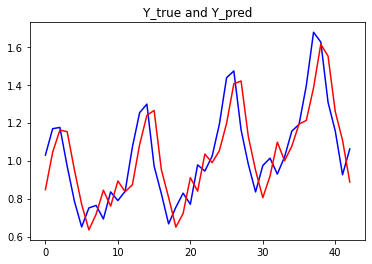

In [ ]:
# plot of y_true in blue and preds in red 
plt.plot(test_scaled[:,2], c="b")
plt.plot(preds, c="r")
plt.title("Y_true and Y_pred")
plt.plot()

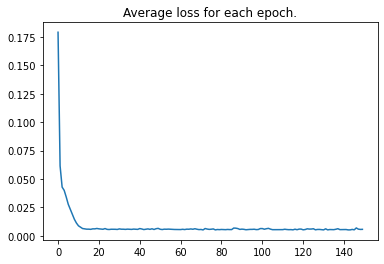

In [ ]:
# this is a plot of the average loss for each epoch  
plt.plot(avg_loss_per_epoch)
plt.title("Average loss for each epoch.")
plt.show()

In [ ]:
mse = mean_squared_error(test_scaled[:,2], preds)
print(f"MSE: {mse:.3f}")

MSE: 0.022


### __Resources:__
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ <br>
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html<br>
https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch <br>
https://discuss.pytorch.org/t/rnn-with-different-sequence-lengths/84922/6 <br>
https://discuss.pytorch.org/t/variable-input-size-to-lstm/61379/2 <br>
https://www.crosstab.io/articles/time-series-pytorch-lstm/ <br>